/tmp/ipykernel_40260/549616188.py:59: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


converged SCF energy = -0.90436139416354  <S^2> = 0  2S+1 = 1
converged SCF energy = -0.90436139416354
d=0.40 | VQE=-0.914150 | UHF=-0.904361 | FCI=-0.914150
converged SCF energy = -1.11613483212156  <S^2> = 4.4408921e-16  2S+1 = 1
converged SCF energy = -1.11613483212156
d=0.68 | VQE=-1.134060 | UHF=-1.116135 | FCI=-1.134060
converged SCF energy = -1.07863600878937  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -1.07863600878937
d=0.95 | VQE=-1.110585 | UHF=-1.078636 | FCI=-1.110585
converged SCF energy = -0.99527253454623  <S^2> = 0  2S+1 = 1
converged SCF energy = -0.995272534546229
d=1.23 | VQE=-1.049961 | UHF=-0.995273 | FCI=-1.049961
converged SCF energy = -0.908575433097412  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -0.908575433097412
d=1.51 | VQE=-0.996925 | UHF=-0.908575 | FCI=-0.996925
converged SCF energy = -0.832641953109437  <S^2> = 0  2S+1 = 1
converged SCF energy = -0.832641953109436
d=1.78 | VQE=-0.963148 | UHF=-0.832642 | FCI=-0.963148
converged

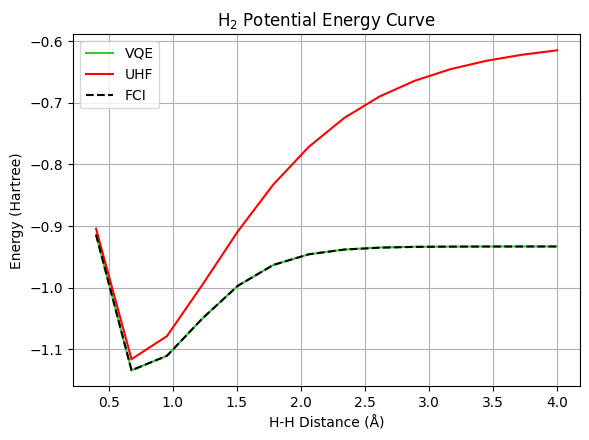

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA

from pyscf import gto, scf, fci


def get_h2_coords(d):
    """Returns coordinates for H2 molecule along z-axis"""
    return [[0, 0, -d / 2], [0, 0, d / 2]]


def get_pyscf_mol(coords, charge, spin, basis):
    atom_spec = ""
    for c in coords:
        atom_spec += f"H {c[0]} {c[1]} {c[2]}; "
    atom_spec = atom_spec.strip("; ")
    mol = gto.Mole()
    mol.atom = atom_spec
    mol.basis = basis
    mol.charge = charge
    mol.spin = spin
    mol.build()
    return mol


def get_qiskit_problem(coords, charge, spin, basis):
    atom_spec = ""
    for c in coords:
        atom_spec += f"H {c[0]} {c[1]} {c[2]}; "
    atom_spec = atom_spec.strip("; ")
    driver = PySCFDriver(atom=atom_spec, unit=DistanceUnit.ANGSTROM,
                         charge=charge, spin=spin, basis=basis)
    return driver.run()


def run_uhf_pyscf(mol):
    mf = scf.UHF(mol)
    ehf = mf.kernel()
    return ehf


def run_fci_pyscf(mol):
    mf = scf.RHF(mol).run()
    cisolver = fci.FCI(mol, mf.mo_coeff)
    efci, _ = cisolver.kernel()
    return efci


def run_vqe(problem, mapper):
    estimator = Estimator()
    optimizer = COBYLA(maxiter=200)
    init_state = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper)
    ansatz = UCCSD(problem.num_spatial_orbitals, problem.num_particles, mapper, initial_state=init_state)
    vqe = VQE(estimator, ansatz, optimizer, initial_point=[0] * ansatz.num_parameters)
    qubit_op = mapper.map(problem.hamiltonian.second_q_op())
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    return problem.interpret(result).total_energies[0].real


# === Main Setup ===
basis = 'sto3g'
charge = 0
spin = 0
dists = np.linspace(0.4, 4.0, 14)

vqe_energies, uhf_energies, fci_energies = [], [], []

for d in dists:
    coords = get_h2_coords(d)

    # VQE
    try:
        problem = get_qiskit_problem(coords, charge, spin, basis)
        mapper = ParityMapper(num_particles=problem.num_particles)
        vqe_energy = run_vqe(problem, mapper)
    except Exception as e:
        vqe_energy = np.nan
        print(f"VQE failed at d={d:.2f}: {e}")

    # UHF
    try:
        mol = get_pyscf_mol(coords, charge, spin, basis)
        uhf_energy = run_uhf_pyscf(mol)
    except Exception as e:
        uhf_energy = np.nan
        print(f"UHF failed at d={d:.2f}: {e}")

    # FCI
    try:
        fci_energy = run_fci_pyscf(mol)
    except Exception as e:
        fci_energy = np.nan
        print(f"FCI failed at d={d:.2f}: {e}")

    vqe_energies.append(vqe_energy)
    uhf_energies.append(uhf_energy)
    fci_energies.append(fci_energy)
    print(f"d={d:.2f} | VQE={vqe_energy:.6f} | UHF={uhf_energy:.6f} | FCI={fci_energy:.6f}")


# === Plotting ===
plt.figure(figsize=(6, 4.5))
plt.plot(dists, vqe_energies, label='VQE', color='limegreen')
plt.plot(dists, uhf_energies, label='UHF', color='red')
plt.plot(dists, fci_energies, '--', label='FCI', color='black')
plt.xlabel("H-H Distance (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("H$_2$ Potential Energy Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_40260/264189328.py:52: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


converged SCF energy = -96.6776869564732  <S^2> = 8.8817842e-16  2S+1 = 1
converged SCF energy = -96.6776869564732
d=0.40 | VQE=-96.679002 | UHF=-96.677687 | FCI=-96.681097
converged SCF energy = -98.3856940980149  <S^2> = 2.3980817e-14  2S+1 = 1
converged SCF energy = -98.3856940980149
d=0.68 | VQE=-98.392996 | UHF=-98.385694 | FCI=-98.397724
converged SCF energy = -98.572843952333  <S^2> = 5.8060223e-12  2S+1 = 1
converged SCF energy = -98.5728439523344
d=0.95 | VQE=-98.597817 | UHF=-98.572844 | FCI=-98.601612
converged SCF energy = -98.5128634993153  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -98.5128634993153
d=1.23 | VQE=-98.561576 | UHF=-98.512863 | FCI=-98.572222
converged SCF energy = -98.411908519881  <S^2> = 1.9575452e-11  2S+1 = 1
converged SCF energy = -98.4119085198785
d=1.51 | VQE=-98.488054 | UHF=-98.411909 | FCI=-98.518020
converged SCF energy = -98.3160333772073  <S^2> = 1.0480505e-13  2S+1 = 1
converged SCF energy = -98.3160333772073
d=1.78 | VQE=-98.4183

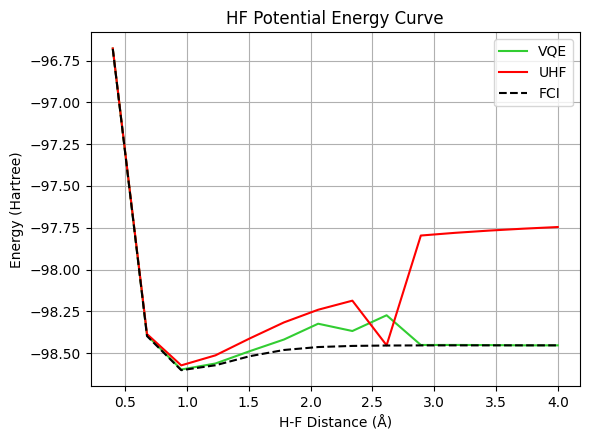

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA

from pyscf import gto, scf, fci


def get_hf_coords(d):
    """Returns coordinates for HF molecule along z-axis"""
    return [["H", [0.0, 0.0, 0.0]], ["F", [0.0, 0.0, d]]]


def get_pyscf_mol(coords, charge, spin, basis):
    mol = gto.Mole()
    mol.atom = coords
    mol.basis = basis
    mol.charge = charge
    mol.spin = spin
    mol.build()
    return mol


def get_qiskit_problem(coords, charge, spin, basis):
    atom_str = "; ".join([f"{atom[0]} {atom[1][0]} {atom[1][1]} {atom[1][2]}" for atom in coords])
    driver = PySCFDriver(atom=atom_str, unit=DistanceUnit.ANGSTROM,
                         charge=charge, spin=spin, basis=basis)
    return driver.run()


def run_uhf_pyscf(mol):
    mf = scf.UHF(mol)
    ehf = mf.kernel()
    return ehf


def run_fci_pyscf(mol):
    mf = scf.RHF(mol).run()
    cisolver = fci.FCI(mol, mf.mo_coeff)
    efci, _ = cisolver.kernel()
    return efci


def run_vqe(problem, mapper):
    estimator = Estimator()
    optimizer = COBYLA(maxiter=200)
    init_state = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper)
    ansatz = UCCSD(problem.num_spatial_orbitals, problem.num_particles, mapper, initial_state=init_state)
    vqe = VQE(estimator, ansatz, optimizer, initial_point=[0] * ansatz.num_parameters)
    qubit_op = mapper.map(problem.hamiltonian.second_q_op())
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    return problem.interpret(result).total_energies[0].real


# === Main Setup ===
basis = 'sto3g'
charge = 0
spin = 0
dists = np.linspace(0.4, 4.0, 14)

vqe_energies, uhf_energies, fci_energies = [], [], []

for d in dists:
    coords = get_hf_coords(d)

    # VQE
    try:
        problem = get_qiskit_problem(coords, charge, spin, basis)
        mapper = ParityMapper(num_particles=problem.num_particles)
        vqe_energy = run_vqe(problem, mapper)
    except Exception as e:
        vqe_energy = np.nan
        print(f"VQE failed at d={d:.2f}: {e}")

    # UHF
    try:
        mol = get_pyscf_mol(coords, charge, spin, basis)
        uhf_energy = run_uhf_pyscf(mol)
    except Exception as e:
        uhf_energy = np.nan
        print(f"UHF failed at d={d:.2f}: {e}")

    # FCI
    try:
        fci_energy = run_fci_pyscf(mol)
    except Exception as e:
        fci_energy = np.nan
        print(f"FCI failed at d={d:.2f}: {e}")

    vqe_energies.append(vqe_energy)
    uhf_energies.append(uhf_energy)
    fci_energies.append(fci_energy)
    print(f"d={d:.2f} | VQE={vqe_energy:.6f} | UHF={uhf_energy:.6f} | FCI={fci_energy:.6f}")


# === Plotting ===
plt.figure(figsize=(6, 4.5))
plt.plot(dists, vqe_energies, label='VQE', color='limegreen')
plt.plot(dists, uhf_energies, label='UHF', color='red')
plt.plot(dists, fci_energies, '--', label='FCI', color='black')
plt.xlabel("H-F Distance (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("HF Potential Energy Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pylab
from qiskit_aer import Aer
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
distances = np.arange(0.5, 4.25, 0.25)

vqe_energies = []
hf_energies = []
exact_energies = []

for i, d in enumerate(distances):
    print('step', i)

    # set up experiment
    driver = PySCFDriver(
        atom=molecule.format(d/2),
        basis='sto3g',
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM
    )
    
    problem = driver.run()
    
    # Apply transformations
    transformer = ActiveSpaceTransformer(
        num_electrons=2,
        num_spatial_orbitals=4
    )
    problem = transformer.transform(problem)
    
    # Use parity mapping with two-qubit reduction
    mapper = ParityMapper(num_particles=problem.num_particles)
    
    # Get the Hamiltonian
    hamiltonian = problem.hamiltonian
    qubit_op = mapper.map(hamiltonian.second_q_op())
    
    # exact classical result
    numpy_solver = NumPyMinimumEigensolver()
    # Convert to dense matrix to avoid sparse matrix issues
    dense_op = qubit_op.to_matrix()
    eigenvalues = np.linalg.eigvals(dense_op)
    exact_energy = np.min(np.real(eigenvalues))
    
    # VQE setup
    optimizer = SLSQP(maxiter=1000)
    
    initial_state = HartreeFock(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        qubit_mapper=mapper
    )
    
    ansatz = UCCSD(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        qubit_mapper=mapper,
        initial_state=initial_state
    )
    
    # VQE algorithm
    estimator = Estimator()
    vqe = VQE(estimator, ansatz, optimizer)
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    
    # Get Hartree-Fock energy by computing expectation value manually
    from qiskit.quantum_info import Statevector
    hf_circuit = initial_state
    hf_statevector = Statevector.from_instruction(hf_circuit)
    hf_energy = np.real(hf_statevector.expectation_value(qubit_op))
    
    exact_energies.append(exact_energy)
    vqe_energies.append(vqe_result.eigenvalue.real)
    hf_energies.append(hf_energy)

pylab.plot(distances, hf_energies, label='Hartree-Fock')
pylab.plot(distances, vqe_energies, label='VQE')
pylab.plot(distances, exact_energies, label='Exact')
pylab.xlabel('Distance (Angstrom)')
pylab.ylabel('Energy (Hartree)')
pylab.legend()
pylab.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA

from pyscf import gto, scf, fci


def get_bh3_coords(d):
    """Returns coordinates for BH3 in trigonal planar configuration"""
    h = d * np.sqrt(3) / 2
    return [
        ["B", [0.0, 0.0, 0.0]],
        ["H", [d, 0.0, 0.0]],
        ["H", [-0.5 * d, h, 0.0]],
        ["H", [-0.5 * d, -h, 0.0]]
    ]


def get_pyscf_mol(coords, charge, spin, basis):
    mol = gto.Mole()
    mol.atom = coords
    mol.basis = basis
    mol.charge = charge
    mol.spin = spin
    mol.build()
    return mol


def get_qiskit_problem(coords, charge, spin, basis):
    atom_str = "; ".join([f"{atom[0]} {atom[1][0]} {atom[1][1]} {atom[1][2]}" for atom in coords])
    driver = PySCFDriver(atom=atom_str, unit=DistanceUnit.ANGSTROM,
                         charge=charge, spin=spin, basis=basis)
    return driver.run()


def run_uhf_pyscf(mol):
    mf = scf.UHF(mol)
    ehf = mf.kernel()
    return ehf


def run_fci_pyscf(mol):
    mf = scf.RHF(mol).run()
    cisolver = fci.FCI(mol, mf.mo_coeff)
    efci, _ = cisolver.kernel()
    return efci


def run_vqe(problem, mapper):
    estimator = Estimator()
    optimizer = COBYLA(maxiter=200)
    init_state = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper)
    ansatz = UCCSD(problem.num_spatial_orbitals, problem.num_particles, mapper, initial_state=init_state)
    vqe = VQE(estimator, ansatz, optimizer, initial_point=[0] * ansatz.num_parameters)
    qubit_op = mapper.map(problem.hamiltonian.second_q_op())
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    return problem.interpret(result).total_energies[0].real


# === Main Setup ===
basis = 'sto3g'
charge = 0
spin = 0
dists = np.linspace(0.4, 4.0, 14)

vqe_energies, uhf_energies, fci_energies = [], [], []

for d in dists:
    coords = get_bh3_coords(d)

    # VQE
    try:
        problem = get_qiskit_problem(coords, charge, spin, basis)
        mapper = ParityMapper(num_particles=problem.num_particles)
        vqe_energy = run_vqe(problem, mapper)
    except Exception as e:
        vqe_energy = np.nan
        print(f"VQE failed at d={d:.2f}: {e}")

    # UHF
    try:
        mol = get_pyscf_mol(coords, charge, spin, basis)
        uhf_energy = run_uhf_pyscf(mol)
    except Exception as e:
        uhf_energy = np.nan
        print(f"UHF failed at d={d:.2f}: {e}")

    # FCI
    try:
        fci_energy = run_fci_pyscf(mol)
    except Exception as e:
        fci_energy = np.nan
        print(f"FCI failed at d={d:.2f}: {e}")

    vqe_energies.append(vqe_energy)
    uhf_energies.append(uhf_energy)
    fci_energies.append(fci_energy)
    print(f"d={d:.2f} | VQE={vqe_energy:.6f} | UHF={uhf_energy:.6f} | FCI={fci_energy:.6f}")


# === Plotting ===
plt.figure(figsize=(6, 4.5))
plt.plot(dists, vqe_energies, label='VQE', color='limegreen')
plt.plot(dists, uhf_energies, label='UHF', color='red')
plt.plot(dists, fci_energies, '--', label='FCI', color='black')
plt.xlabel("B-H Distance (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("BH$_3$ Potential Energy Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_40260/1015372945.py:58: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA

from pyscf import gto, scf, fci


def get_lih_coords(d):
    """Returns Li-H linear geometry at a given bond distance d (Å)"""
    return [["H", [0.0, 0.0, 0.0]], ["Li", [0.0, 0.0, d]]]


def get_pyscf_mol(coords, charge, spin, basis):
    mol = gto.Mole()
    mol.atom = coords
    mol.basis = basis
    mol.charge = charge
    mol.spin = spin
    mol.build()
    return mol


def get_qiskit_problem(coords, charge, spin, basis):
    atom_str = "; ".join([f"{atom[0]} {atom[1][0]} {atom[1][1]} {atom[1][2]}" for atom in coords])
    driver = PySCFDriver(atom=atom_str, unit=DistanceUnit.ANGSTROM,
                         charge=charge, spin=spin, basis=basis)
    return driver.run()


def run_uhf_pyscf(mol):
    mf = scf.UHF(mol)
    ehf = mf.kernel()
    return ehf


def run_fci_pyscf(mol):
    mf = scf.RHF(mol).run()
    cisolver = fci.FCI(mol, mf.mo_coeff)
    efci, _ = cisolver.kernel()
    return efci


def run_vqe(problem, mapper):
    estimator = Estimator()
    optimizer = COBYLA(maxiter=200)
    init_state = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper)
    ansatz = UCCSD(problem.num_spatial_orbitals, problem.num_particles, mapper, initial_state=init_state)
    vqe = VQE(estimator, ansatz, optimizer, initial_point=[0] * ansatz.num_parameters)
    qubit_op = mapper.map(problem.hamiltonian.second_q_op())
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    return problem.interpret(result).total_energies[0].real


# === Main Setup ===
basis = 'sto3g'
charge = 0
spin = 0
dists = np.linspace(0.5, 4.0, 15)

vqe_energies, uhf_energies, fci_energies = [], [], []

for d in dists:
    coords = get_lih_coords(d)

    # VQE
    try:
        problem = get_qiskit_problem(coords, charge, spin, basis)
        mapper = ParityMapper(num_particles=problem.num_particles)
        vqe_energy = run_vqe(problem, mapper)
    except Exception as e:
        vqe_energy = np.nan
        print(f"VQE failed at d={d:.2f}: {e}")

    # UHF
    try:
        mol = get_pyscf_mol(coords, charge, spin, basis)
        uhf_energy = run_uhf_pyscf(mol)
    except Exception as e:
        uhf_energy = np.nan
        print(f"UHF failed at d={d:.2f}: {e}")

    # FCI
    try:
        fci_energy = run_fci_pyscf(mol)
    except Exception as e:
        fci_energy = np.nan
        print(f"FCI failed at d={d:.2f}: {e}")

    vqe_energies.append(vqe_energy)
    uhf_energies.append(uhf_energy)
    fci_energies.append(fci_energy)
    print(f"d={d:.2f} | VQE={vqe_energy:.6f} | UHF={uhf_energy:.6f} | FCI={fci_energy:.6f}")


# === Plotting ===
plt.figure(figsize=(6, 4.5))
plt.plot(dists, vqe_energies, label='VQE', color='limegreen')
plt.plot(dists, uhf_energies, label='UHF', color='red')
plt.plot(dists, fci_energies, '--', label='FCI', color='black')
plt.xlabel("Li-H Distance (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("LiH Potential Energy Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_56096/2930526045.py:51: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


converged SCF energy = -7.02841009454055  <S^2> = 2.851408e-11  2S+1 = 1
converged SCF energy = -7.02841009454193
d=0.50 | VQE=-7.032225 | UHF=-7.028410 | FCI=-7.050225
converged SCF energy = -7.55672166024707  <S^2> = 1.7541524e-14  2S+1 = 1
converged SCF energy = -7.5567216602468
d=0.75 | VQE=-7.556722 | UHF=-7.556722 | FCI=-7.575487
converged SCF energy = -7.76736213570591  <S^2> = 7.2588113e-10  2S+1 = 1
converged SCF energy = -7.76736213574856
d=1.00 | VQE=-7.767362 | UHF=-7.767362 | FCI=-7.784460
converged SCF energy = -7.84490531557108  <S^2> = 4.7037041e-11  2S+1 = 1
converged SCF energy = -7.84490531557396
d=1.25 | VQE=-7.844905 | UHF=-7.844905 | FCI=-7.861861
converged SCF energy = -7.86335762152993  <S^2> = 1.0081225e-10  2S+1 = 1
converged SCF energy = -7.86335762153512
d=1.50 | VQE=-7.863358 | UHF=-7.863358 | FCI=-7.882362
converged SCF energy = -7.85383960184028  <S^2> = 8.2511775e-13  2S+1 = 1
converged SCF energy = -7.85383960184052
d=1.75 | VQE=-7.853840 | UHF=-7.85384